# 

# 

# 

# 

# 

# 작사가 인공지능 만들기

## 들어가며

## 시퀀스? 스퀀스!

## I 대신 am을 쓰면 반 이상은 맞더라

In [2]:
sentence = " 나는 밥을 먹었다 "
# <start>는 문장의 시작 입니다. 
# <start> 토큰을 받은 순환 신경망은 "나는"을 출력한다.
# 출력된 "나는"이라는 단어를 다시 입력으로 사용하고 이러한 반복을 통해 "먹었다"까지 
# 글을 생성한다. 마지막으로 끝(완성)을 뜻하는 <end> 토큰을 생성하여 마무리 합니다. 
source_sentence = "<start>" + sentence
target_sentence = sentence + "<end>"

print("Source 문장:", source_sentence)
# Source 문장: <start> 나는 밥을 먹었다
print("Target 문장:", target_sentence)
# Target 문장:  나는 밥을 먹었다 <end>

Source 문장: <start> 나는 밥을 먹었다 
Target 문장:  나는 밥을 먹었다 <end>


## 실습 (1) 데이터 다듬기

### `raw_corpus`

In [3]:
import os, re 
import numpy as np
import tensorflow as tf

file_path = '../../data/exploration_06/data/shakespeare.txt'
with open(file_path, "r") as f:
    raw_corpus = f.read().splitlines()

print(raw_corpus[:9])

['First Citizen:', 'Before we proceed any further, hear me speak.', '', 'All:', 'Speak, speak.', '', 'First Citizen:', 'You are all resolved rather to die than to famish?', '']


### 

In [4]:
# enumerate() 함수를 이용하여 raw_corpus list 내에 저장된 문장과 그 문장의 인덱스를 반환 (인덱스, 문장 순)
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 9: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

Before we proceed any further, hear me speak.
Speak, speak.
You are all resolved rather to die than to famish?


### `preprocess_sentence`

In [5]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


- before :__Linear-algebra is a central branch of mathetmatics. Is calculus more important than linear-algebra? I don't know."
- after : \<start\>linear algebra is a central branch of mathetmatics. is calculus more important than linear algebra? i don t know. \<end\>
- before : This @_is ;;;sample________sentence.
- after : \<start\>this is sample sentence. \<end\>

### `corpus`

In [6]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> before we proceed any further , hear me speak . <end>',
 '<start> speak , speak . <end>',
 '<start> you are all resolved rather to die than to famish ? <end>',
 '<start> resolved . resolved . <end>',
 '<start> first , you know caius marcius is chief enemy to the people . <end>',
 '<start> we know t , we know t . <end>',
 '<start> let us kill him , and we ll have corn at our own price . <end>',
 '<start> is t a verdict ? <end>',
 '<start> no more talking on t let it be done away , away ! <end>',
 '<start> one word , good citizens . <end>']

In [7]:
len(corpus)

24015

### `tensor`, `tokenizer`

In [8]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    # tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    # tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2  143   40 ...    0    0    0]
 [   2  110    4 ...    0    0    0]
 [   2   11   50 ...    0    0    0]
 ...
 [   2  149 4553 ...    0    0    0]
 [   2   34   71 ...    0    0    0]
 [   2  945   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f21048ccb80>


In [9]:
print(type(corpus))
print(len(corpus))

<class 'list'>
24015


In [10]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=7000, filters=' ',
                                                  oov_token="<unk>")

In [11]:
tokenizer.fit_on_texts(corpus)

In [12]:
tensor = tokenizer.texts_to_sequences(corpus)

In [13]:
print(type(tensor))
print(len(tensor))

<class 'list'>
24015


In [14]:
tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

In [15]:
print(type(tensor))
print(tensor.shape)

<class 'numpy.ndarray'>
(24015, 21)


In [16]:
print(type(tensor))
print(tensor.shape) #24015개의 문장, 각 문장은 21차원의 벡터
print(corpus[0])
print(corpus[1])
print(corpus[2])
print(tensor[0])
print(tensor[1])
print(tensor[2])

<class 'numpy.ndarray'>
(24015, 21)
<start> before we proceed any further , hear me speak . <end>
<start> speak , speak . <end>
<start> you are all resolved rather to die than to famish ? <end>
[  2 143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0
   0   0   0]
[  2 110   4 110   5   3   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
[   2   11   50   43 1201  316    9  201   74    9 3034   15    3    0
    0    0    0    0    0    0    0]


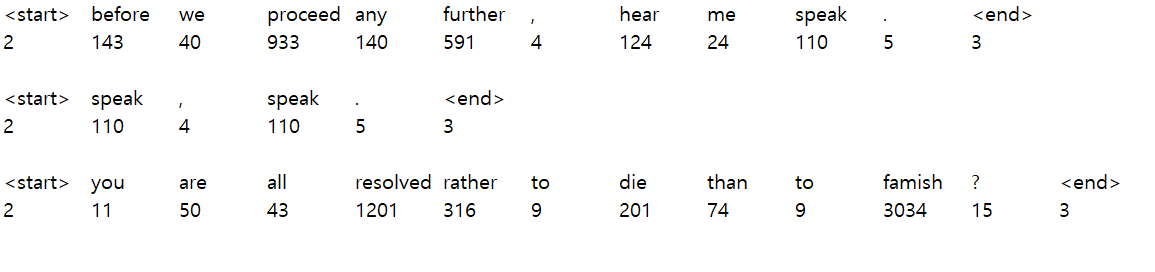

In [17]:
print(type(tokenizer))
print(dir(tokenizer))

<class 'keras_preprocessing.text.Tokenizer'>
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_keras_api_names', '_keras_api_names_v1', 'char_level', 'document_count', 'filters', 'fit_on_sequences', 'fit_on_texts', 'get_config', 'index_docs', 'index_word', 'lower', 'num_words', 'oov_token', 'sequences_to_matrix', 'sequences_to_texts', 'sequences_to_texts_generator', 'split', 'texts_to_matrix', 'texts_to_sequences', 'texts_to_sequences_generator', 'to_json', 'word_counts', 'word_docs', 'word_index']


- `fit_on_texts` : Updates internal vocabulary based on a list of texts.
- `texts_to_sequences` : Transforms each text in texts to a sequence of integers.
- `index_word` : 
- `num_words` : the maximum number of words to keep, based on word frequency
- `filters` : a string where each element is a character that will be filtered from the texts.
- `oov_token` : if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls

In [18]:
print(type(tokenizer.index_word))
print(len(tokenizer.index_word))

<class 'dict'>
11179


In [19]:
print(tokenizer.num_words)
print(tokenizer.filters)
print(tokenizer.oov_token)

7000
 
<unk>


### 

In [20]:
print(tensor[:3, :10])

[[   2  143   40  933  140  591    4  124   24  110]
 [   2  110    4  110    5    3    0    0    0    0]
 [   2   11   50   43 1201  316    9  201   74    9]]


### `tokenizer.index_word`

In [21]:
# tokenizer.index_word: 현재 계산된 단어의 인덱스와 인덱스에 해당하는 단어를 dictionary 형대로 반환 (Ex. {index: '~~', index: '~~', ...})
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break
print(0 in tokenizer.index_word)

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : .
6 : the
7 : and
8 : i
9 : to
10 : of
False


### `src_input`, `tgt_input`

In [22]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2 143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0
   0   0]
[143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0   0
   0   0]


### `dataset`

In [23]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
 # tokenizer.num_words: 주어진 데이터의 문장들에서 빈도수가 높은 n개의 단어만 선택
 # tokenize() 함수에서 num_words를 7000개로 선언했기 때문에, tokenizer.num_words의 값은 7000
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 20), (256, 20)), types: (tf.int32, tf.int32)>

In [24]:
print(len(src_input))
print(256)
print(len(src_input)//256)

24015
256
93


In [25]:
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))

In [26]:
dataset_as_np_array = np.array([data for data in dataset])
print(dataset_as_np_array.shape)

(24015, 2, 20)


In [27]:
print(dataset_as_np_array[0,0])
print(dataset_as_np_array[0,1])
print(dataset_as_np_array[1,0])
print(dataset_as_np_array[1,1])

[  2 143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0
   0   0]
[143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0   0
   0   0]
[  2 110   4 110   5   3   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
[110   4 110   5   3   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


In [28]:
dataset = dataset.shuffle(BUFFER_SIZE)
dataset_as_np_array = np.array([data for data in dataset])
print(dataset_as_np_array.shape)

(24015, 2, 20)


In [29]:
print(dataset_as_np_array[0,0])
print(dataset_as_np_array[0,1])
print(dataset_as_np_array[1,0])
print(dataset_as_np_array[1,1])

[   2 3875    4   32   23   84    4   57    6 1508   10 4316    3    0
    0    0    0    0    0    0]
[3875    4   32   23   84    4   57    6 1508   10 4316    3    0    0
    0    0    0    0    0    0]
[  2  20   8  31 603  66  12 214  21 707   3   0   0   0   0   0   0   0
   0   0]
[ 20   8  31 603  66  12 214  21 707   3   0   0   0   0   0   0   0   0
   0   0]


In [30]:
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
print(type(dataset))
print(len(dataset))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
93


In [31]:
dataset_as_np_array = np.array([data for data in dataset])
print(dataset_as_np_array.shape)

(93, 2, 256, 20)


In [32]:
print(dataset_as_np_array[0,0])
print(dataset_as_np_array[0,1])
print(dataset_as_np_array[1,0])
print(dataset_as_np_array[1,1])

[[   2    7 3917 ...    0    0    0]
 [   2  765    8 ...    0    0    0]
 [   2   84   23 ...    0    0    0]
 ...
 [   2  377  681 ...    0    0    0]
 [   2  105 1853 ...    0    0    0]
 [   2  590    4 ...    0    0    0]]
[[   7 3917  232 ...    0    0    0]
 [ 765    8  169 ...    0    0    0]
 [  84   23    9 ...    0    0    0]
 ...
 [ 377  681   12 ...    0    0    0]
 [ 105 1853   67 ...    0    0    0]
 [ 590    4   85 ...    0    0    0]]
[[   2   62  147 ...    0    0    0]
 [   2   19    4 ...    0    0    0]
 [   2   49  969 ...    0    0    0]
 ...
 [   2    9  298 ...    0    0    0]
 [   2   86 1984 ...    0    0    0]
 [   2   22 2907 ...    0    0    0]]
[[  62  147    8 ...    0    0    0]
 [  19    4   91 ...    0    0    0]
 [  49  969    4 ...    0    0    0]
 ...
 [   9  298   44 ...    0    0    0]
 [  86 1984    6 ...    0    0    0]
 [  22 2907   14 ...    0    0    0]]


In [33]:
dataset

<BatchDataset shapes: ((256, 20), (256, 20)), types: (tf.int32, tf.int32)>

## 실습 (2) 인공지능 학습시키기

### `model`

In [34]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다. 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만
# 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져옵니다!   
embedding_size = 256 # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
hidden_size = 1024 # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) # tokenizer.num_words에 +1인 이유는 문장에 없는 pad가 사용되었기 때문이다.

### 

In [74]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 20, 7001), dtype=float32, numpy=
array([[[ -3.0514135 ,   3.6969502 ,  -8.831471  , ...,  -8.81112   ,
          -8.012526  ,  -8.651166  ],
        [ -3.5106676 ,   6.4686856 ,  -8.977999  , ..., -11.058538  ,
         -11.372764  ,  -8.5872    ],
        [ -5.1337075 ,   6.1280274 , -10.608118  , ...,  -8.57676   ,
         -10.895319  , -10.190677  ],
        ...,
        [ 16.253113  ,   0.18009357, -21.84259   , ..., -27.626005  ,
         -24.315926  , -21.241253  ],
        [ 16.265593  ,   0.251688  , -21.862291  , ..., -27.694239  ,
         -24.292906  , -21.255611  ],
        [ 16.263536  ,   0.39460325, -21.885323  , ..., -27.792274  ,
         -24.206167  , -21.269848  ]],

       [[ -3.0514135 ,   3.6969502 ,  -8.831471  , ...,  -8.81112   ,
          -8.012526  ,  -8.651166  ],
        [ -0.99496937,   3.5168676 , -11.649495  , ..., -12.955412  ,
         -15.17435   , -11.475777  ],
        [ -0.7281848 ,   3.1874876 , -15.804045  , ..., -16.2499

In [36]:
dataset_as_np_array = np.array([data for data in dataset])
print(dataset_as_np_array.shape) #batch, src/tgt, batch_size, length_of_sentences

(93, 2, 256, 20)


In [37]:
sample_as_np_array = np.array([data for data in dataset.take(1)])
print(sample_as_np_array.shape)

(1, 2, 256, 20)


In [39]:
prd_sample = model(src_sample)
print(type(prd_sample))
prd_sample_as_np_array = np.array([data for data in prd_sample])
print(prd_sample.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(256, 20, 7001)


- 이 모델의 입력값은 `src_sample`이다.
  - `src_sample`의 shape은 (1, 1, 256, 20)으로 추정된다.
- 이 모델의 입력값에 대한 라벨은 `tgt_sample`이다.
  - `tgt_sample`의 shape은 (1, 1, 256, 20)으로 추정된다.
  - `src_sample`과 `tgt_sample`은 `dataset.take(1)`와 같은 명령어로 한꺼번에 불러와진다.
  - `dataset.take(1)`의 shape은 (1, 2, 256, 20)이다.
  - `dataset`의 shape은 (93, 2, 256, 20)이었다.
  이때 각각의 rank는 `steps_per_epoch`, src/tgt, 배치의 크기, 문장의 길이 (단어의 최대 개수)를 나타낸다.
  - `dataset.take(1)`는 `dataset`의 첫번째 step까지를 포착한 것이다.
- 이 모델의 출력값인 `model(src_sample)`을 `prd_sample`로 두었다.
  - `prd_sample`의 shape은 (256, 20, 7001)로 추정된다.
  - 앞의 256과 20의 의미에 대해서는 명확하다.
  각각 배치 사이즈와 문장 길이이다.
  - 7001은 예측할 단어를 one-hot vector로 표현했기 때문에 나타나는 것 같다.
  - 즉, 이 tensor의 `[a,b,:]`는 7001차원의 one-hot vector가 나타날 것이다.
  이 벡터는 a번째 배치의 b번째 문장이 주어졌을 때, 그 다음으로 나올 단어에 대한 one-hot vector일 것이다.
  - 그러니까, `tgt_sample`과 `prd_sample`의 shape이 서로 다르다.
  따라서 `prd_sample`에 대한 어떤 종류의 처리가 앞으로 필요할 것이다.
- 위의 논리를 통해서 보면, dataset은 (그중에서도 src에 해당하는 부분은) 다음과 같은 hierachy가 존재함을 알 수 있다.

dataset (93, 2, 256, 20)

├── batch 1 (2, 256, 20)

    ├── src (256, 20)

        ├── sentence 1 (20,)

        ：

        └── sentence 20 (20,)

    ：

    └── tgt (256, 20)

        ├── sentence 1 (20,)

        ：

        └── sentence 20 (20,)

：

├── batch 93 (2, 256, 20)

    ├── src (256, 20)

        ├── sentence 1 (20,)

        ：

        └── sentence 20 (20,)

    ：

    └── tgt (256, 20)

        ├── sentence 1 (20,)

        ：

        └── sentence 20 (20,)

### 

In [13]:
# 모델의 구조를 확인합니다.
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1792256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  7176025   
Total params: 22,607,961
Trainable params: 22,607,961
Non-trainable params: 0
_________________________________________________________________


### `model.fit`, `model.compile`

In [40]:
# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다

# Adam 알고리즘을 구현하는 optimzier이며 어떤 optimzier를 써야할지 모른다면 Adam을 쓰는 것도 방법이다.
# 우리가 학습을 할 때 최대한 틀리지 않는 방향으로 학습을 해야한다.
# 여기서 얼마나 틀리는지(loss)를 알게하는 함수가 손실함수 이다.
# 이 손실함수의 최소값을 찾는 것을 학습의 목표로 하며 여기서 최소값을 찾아가는 과정을 optimization 이라하고
# 이를 수행하는 알고리즘을 optimizer(최적화)라고 한다.

optimizer = tf.keras.optimizers.Adam() # Adam은 현재 가장 많이 사용하는 옵티마이저이다. 자세한 내용은 차차 배운다.
loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수이다.
    from_logits=True, # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다. 
    reduction='none'  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용한다.
)
# 모델을 학습시키키 위한 학습과정을 설정하는 단계이다.
model.compile(loss=loss, optimizer=optimizer) # 손실함수와 훈련과정을 설정했다.
model.fit(dataset, epochs=30) # 만들어둔 데이터셋으로 모델을 학습한다. 30번 학습을 반복하겠다는 의미다.

Epoch 1/30
93/93 [==============================] - 19s 180ms/step - loss: 3.4687
Epoch 2/30
93/93 [==============================] - 18s 188ms/step - loss: 2.8019
Epoch 3/30
93/93 [==============================] - 19s 200ms/step - loss: 2.6990
Epoch 4/30
93/93 [==============================] - 19s 206ms/step - loss: 2.5956
Epoch 5/30
93/93 [==============================] - 19s 199ms/step - loss: 2.5294
Epoch 6/30
93/93 [==============================] - 18s 195ms/step - loss: 2.4764
Epoch 7/30
93/93 [==============================] - 18s 198ms/step - loss: 2.4202
Epoch 8/30
93/93 [==============================] - 19s 200ms/step - loss: 2.3670
Epoch 9/30
93/93 [==============================] - 19s 201ms/step - loss: 2.3153
Epoch 10/30
93/93 [==============================] - 19s 200ms/step - loss: 2.2641
Epoch 11/30
93/93 [==============================] - 19s 199ms/step - loss: 2.2150
Epoch 12/30
93/93 [==============================] - 19s 199ms/step - loss: 2.1685
Epoch 13/30
9

## 실습 (3) 잘 만들어졌는지 평가하기

### 

In [41]:
#문장생성 함수 정의
#모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20): #시작 문자열을 init_sentence 로 받으며 디폴트값은 <start> 를 받는다
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다 (도달 하지 못하였으면 while 루프를 돌면서 다음 단어를 예측)
    while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성성
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

In [42]:
init_sentence = "<start> he sat on"

In [43]:
test_input = tokenizer.texts_to_sequences([init_sentence])

In [44]:
test_input

[[2, 27, 3180, 52]]

In [45]:
test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)

In [46]:
test_tensor

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   2,   27, 3180,   52]])>

In [47]:
end_token = tokenizer.word_index["<end>"]
end_token

3

In [48]:
predict = model(test_tensor)
predict

<tf.Tensor: shape=(1, 4, 7001), dtype=float32, numpy=
array([[[ -3.051416 ,   3.696951 ,  -8.831473 , ...,  -8.811118 ,
          -8.012525 ,  -8.651165 ],
        [ -3.2565126,   5.6126227,  -9.304058 , ..., -11.500596 ,
         -14.960632 ,  -9.114545 ],
        [ -4.4368005,   4.350048 , -11.46468  , ..., -12.195612 ,
          -8.785845 , -11.178638 ],
        [ -4.5176725,   3.8872557, -11.611043 , ...,  -8.24683  ,
          -5.747051 , -11.250833 ]]], dtype=float32)>

In [53]:
predict[0,0,:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-3.051416  ,  3.696951  , -8.831473  , -0.98473465, -4.0406938 ,
       -5.806791  ,  4.6388636 ,  5.161111  ,  5.045443  ,  4.4601064 ],
      dtype=float32)>

In [49]:
tf.nn.softmax(predict, axis = -1)

<tf.Tensor: shape=(1, 4, 7001), dtype=float32, numpy=
array([[[1.7487160e-05, 1.4910685e-02, 5.4009732e-08, ...,
         5.5120374e-08, 1.2250024e-07, 6.4681338e-08],
        [2.8071127e-06, 1.9956132e-02, 6.6350503e-09, ...,
         7.3773343e-10, 2.3185969e-11, 8.0195193e-09],
        [2.8612494e-06, 1.8734207e-02, 2.5373847e-09, ...,
         1.2216492e-09, 3.6964902e-08, 3.3776331e-09],
        [1.2564150e-06, 5.6149671e-03, 1.0435698e-09, ...,
         3.0170398e-08, 3.6746937e-07, 1.4960939e-09]]], dtype=float32)>

In [54]:
tf.nn.softmax(predict, axis = -1)[0,0,:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.7487160e-05, 1.4910685e-02, 5.4009732e-08, 1.3812345e-04,
       6.5025092e-06, 1.1119242e-06, 3.8244151e-02, 6.4472444e-02,
       5.7430193e-02, 3.1983927e-02], dtype=float32)>

In [50]:
tf.argmax(tf.nn.softmax(predict, axis = -1),axis=-1)

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 7, 18,  4, 24]])>

In [30]:
tf.argmax(tf.nn.softmax(predict, axis = -1),axis=-1)[:,-1]

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([24])>

In [55]:
predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]

In [56]:
predict_word

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([24])>

In [57]:
test_tensor

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   2,   27, 3180,   52]])>

In [58]:
tf.expand_dims(predict_word,axis=0)

<tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[24]])>

In [59]:
test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
test_tensor

<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[   2,   27, 3180,   52,   24]])>

In [60]:
predict = model(test_tensor)
predict

<tf.Tensor: shape=(1, 5, 7001), dtype=float32, numpy=
array([[[ -3.0514162,   3.696951 ,  -8.831473 , ...,  -8.811117 ,
          -8.012525 ,  -8.651165 ],
        [ -3.2565129,   5.6126227,  -9.304058 , ..., -11.500596 ,
         -14.960633 ,  -9.114545 ],
        [ -4.4368005,   4.350048 , -11.464679 , ..., -12.195612 ,
          -8.785845 , -11.178638 ],
        [ -4.517672 ,   3.8872557, -11.611043 , ...,  -8.24683  ,
          -5.7470512, -11.250833 ],
        [ -1.6840702,   2.3764992, -12.582758 , ..., -17.401278 ,
         -17.443468 , -12.404248 ]]], dtype=float32)>

In [61]:
predict[0,0,:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-3.0514162,  3.696951 , -8.831473 , -0.9847348, -4.0406938,
       -5.806791 ,  4.6388636,  5.161111 ,  5.045443 ,  4.4601064],
      dtype=float32)>

In [62]:
tf.nn.softmax(predict, axis = -1)

<tf.Tensor: shape=(1, 5, 7001), dtype=float32, numpy=
array([[[1.7487144e-05, 1.4910685e-02, 5.4009732e-08, ...,
         5.5120431e-08, 1.2250024e-07, 6.4681338e-08],
        [2.8071124e-06, 1.9956131e-02, 6.6350498e-09, ...,
         7.3773337e-10, 2.3185922e-11, 8.0195184e-09],
        [2.8612467e-06, 1.8734209e-02, 2.5373872e-09, ...,
         1.2216480e-09, 3.6964902e-08, 3.3776362e-09],
        [1.2564160e-06, 5.6149671e-03, 1.0435707e-09, ...,
         3.0170366e-08, 3.6746897e-07, 1.4960951e-09],
        [3.4399192e-05, 1.9954059e-03, 6.3578232e-10, ...,
         5.1363189e-12, 4.9241227e-12, 7.6003687e-10]]], dtype=float32)>

In [63]:
tf.nn.softmax(predict, axis = -1)[0,0,:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.7487144e-05, 1.4910685e-02, 5.4009732e-08, 1.3812345e-04,
       6.5025092e-06, 1.1119242e-06, 3.8244151e-02, 6.4472444e-02,
       5.7430193e-02, 3.1983927e-02], dtype=float32)>

In [64]:
tf.argmax(tf.nn.softmax(predict, axis = -1),axis=-1)

<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[ 7, 18,  4, 24,  4]])>

In [65]:
tf.argmax(tf.nn.softmax(predict, axis = -1),axis=-1)[:,-1]

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([4])>

In [66]:
predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]

In [67]:
predict_word

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([4])>

In [68]:
test_tensor

<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[   2,   27, 3180,   52,   24]])>

In [69]:
tf.expand_dims(predict_word,axis=0)

<tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[4]])>

In [70]:
test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
test_tensor

<tf.Tensor: shape=(1, 6), dtype=int64, numpy=array([[   2,   27, 3180,   52,   24,    4]])>

### 

In [73]:
generate_text(model, tokenizer, init_sentence="<start> he sat on") # 시작문장으로 he를 넣어 문장생성 함수 실행

'<start> he sat on me , and i am sure of all . <end> '

## 프로젝트 : 멋진 작사가 만들기

## 프로젝트 제출